In [7]:
#Libraries
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
#Load DF
world_cup_df = pd.read_csv('../Project Reference Materials/fifa_world_cup.csv')

# Can you predict what team is most likely to win the 2022 FIFA World Cup?
## - What are the key variables that explain which team has higher chance winning?
## - Can we calculate the expected winning rate for each team based on the history?

In [12]:
#changing date data from a string to datetime object
world_cup_df['date'] = pd.to_datetime(world_cup_df['date'], errors = 'coerce')

In [14]:
#Checking to see if any dates went unconverted
bad_dates = world_cup_df[world_cup_df['date'].isna()]
print(f'Found {len(bad_dates)} rows with unconvertible dates.')
bad_dates.head()

Found 0 rows with unconvertible dates.


,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score


In [16]:
#create a more simple year column
world_cup_df['year'] = world_cup_df['date'].dt.year
#Checking to see if it worked
world_cup_df[['date', 'year']].head(10)
#checking for missing values
world_cup_df['year'].isna().sum()

0

In [18]:
#Creating a winner index (regardless of away or home)
def get_winner(row):
    if row['home_team_score'] > row['away_team_score']:
        return row['home_team']
    elif row['home_team_score'] < row['away_team_score']:
        return row['away_team']
    else:
        return 'Draw'

world_cup_df['winner'] = world_cup_df.apply(get_winner, axis=1)


In [20]:
# Home team perspective
home_df = world_cup_df[['year', 'home_team', 'away_team', 'winner']].copy()
home_df['team'] = home_df['home_team']
home_df['opponent'] = home_df['away_team']
home_df['result'] = home_df.apply(
    lambda x: 'Win' if x['winner'] == x['team']
    else 'Draw' if x['winner'] == 'Draw'
    else 'Loss', axis=1
)

# Away team perspective
away_df = world_cup_df[['year', 'away_team', 'home_team', 'winner']].copy()
away_df['team'] = away_df['away_team']
away_df['opponent'] = away_df['home_team']
away_df['result'] = away_df.apply(
    lambda x: 'Win' if x['winner'] == x['team']
    else 'Draw' if x['winner'] == 'Draw'
    else 'Loss', axis=1
)

# Combine both views
team_matches = pd.concat([home_df[['year', 'team', 'result']], away_df[['year', 'team', 'result']]])

In [22]:
#preview new data 
team_matches.head(10)


,year,team,result
0,1993,Bolivia,Win
1,1993,Brazil,Draw
2,1993,Ecuador,Win
3,1993,Guinea,Win
4,1993,Paraguay,Loss
5,1993,Peru,Loss
6,1993,Zimbabwe,Win
7,1993,Guinea,Win
8,1993,Faroe Islands,Loss
9,1993,Sweden,Loss


In [24]:
# Total matches per team
total_matches = team_matches.groupby('team').size()

# Total wins per team
total_wins = team_matches[team_matches['result'] == 'Win'].groupby('team').size()


In [26]:
win_stats = pd.DataFrame({
    'Matches Played': total_matches,
    'Wins': total_wins
})

# Fill any missing Wins (i.e., teams with 0 wins) with 0
win_stats['Wins'] = win_stats['Wins'].fillna(0)

# Calculate win percentage
win_stats['Win %'] = (win_stats['Wins'] / win_stats['Matches Played']) * 100

# Sort by win percentage
win_stats = win_stats.sort_values('Win %', ascending=False)

In [28]:
win_stats.head(10)  # Top 10 most successful countries by win rate
top10 = win_stats.sort_values('Win %', ascending=False).head(10)

(0.0, 100.0)

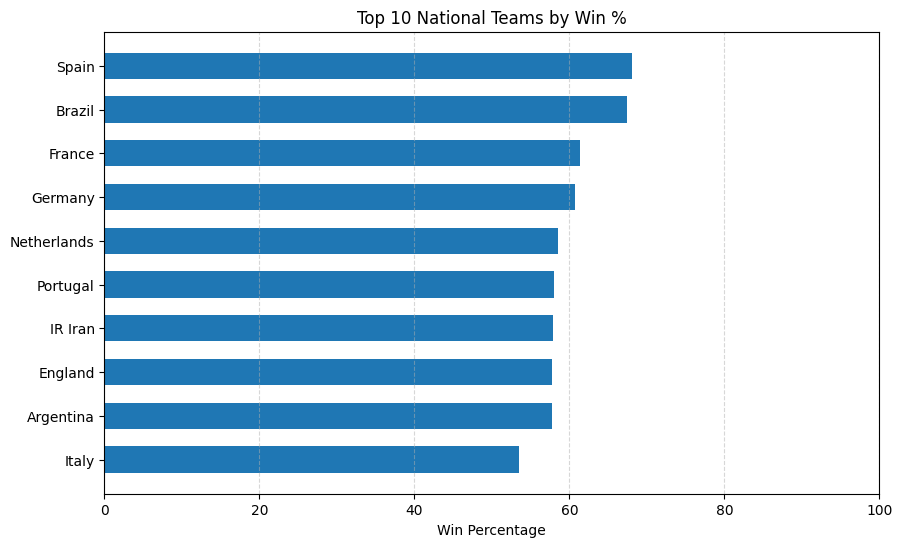

In [30]:
plt.figure(figsize=(10, 6))
bars = plt.barh(top10.index[::-1], top10['Win %'][::-1], height=0.6)
plt.xlabel("Win Percentage")
plt.title("Top 10 National Teams by Win %")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xlim(0, 100)

## Top 10 National Teams by Historical Win Percentage

In this chart, we calculated the win percentage for each national team based on their **entire history of World Cup matches**, excluding draws. The process included the following steps:

1. **Filtered the Dataset:** Limited the data to only matches from the "FIFA World Cup" tournament to focus on relevant games.
2. **Created a 'Winner' Column:** Determined the winner for each match by comparing the number of goals scored by the home and away teams.
3. **Excluded Draws:** Since draws don't help identify which team was superior, we excluded them from the win percentage calculation.
4. **Calculated Win Percentage:** 
   - Counted the number of wins per team.
   - Counted the number of non-draw games played by each team.
   - Divided wins by non-draw games to calculate the win rate.
5. **Sorted and Visualized:** Sorted the teams by win percentage and plotted the top 10 in a horizontal bar chart.

### What the Visual Shows:

- **Spain and Brazil** lead in terms of historical win percentage, followed closely by **France** and **Germany**.
- Teams like **Portugal, Netherlands, and England** also appear in the top 10 based on consistent past performance.
- **Argentina** appears lower on the list despite winning the 2022 World Cup.

### Limitations of This Method:

This method **scores all wins and losses equally**, regardless of how long ago the match occurred. That means a win from 1950 is treated the same as a win in 2018 or 2022.

> ⚠️ Because of that, this historical approach turned out to be mostly inaccurate — **Argentina won the 2022 World Cup**, yet they do not top the chart using this method. This highlights the importance of factoring in **recency** and potentially other performance metrics if we want to make more accurate predictions.


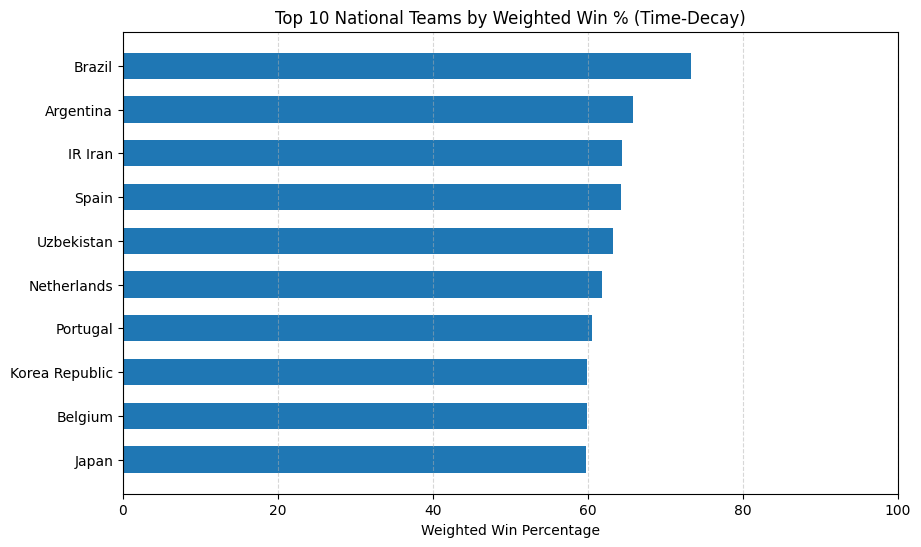

In [36]:
# Get the latest year in the dataset to use in decay calculation
latest_year = team_matches['year'].max()

# Set decay rate
decay_rate = 3

# Apply decay rate for each match 
team_matches['weight'] = team_matches['year'].apply(
    lambda y: max(0.01, 1 / (1 + decay_rate * (latest_year - y)))
)

# Calculate total weighted matches per team 
weighted_total = team_matches.groupby('team')['weight'].sum()

# Calculate weighted wins per team
weighted_wins = team_matches[team_matches['result'] == 'Win'].groupby('team')['weight'].sum()

# Build weighted stats DataFrame
weighted_stats = pd.DataFrame({
    'Weighted Matches': weighted_total,
    'Weighted Wins': weighted_wins
}).fillna(0)

# Calculate time-decay weighted Win % per team
weighted_stats['Weighted Win %'] = (weighted_stats['Weighted Wins'] / weighted_stats['Weighted Matches']) * 100

# Grab top 10
top10_weighted = weighted_stats.sort_values('Weighted Win %', ascending=False).head(10)

# Plot it visually
plt.figure(figsize=(10, 6))
bars = plt.barh(top10_weighted.index[::-1], top10_weighted['Weighted Win %'][::-1], height=0.6)
plt.xlabel("Weighted Win Percentage")
plt.title("Top 10 National Teams by Weighted Win % (Time-Decay)")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xlim(0, 100)
plt.show()


## Top 10 National Teams by Weighted Win Percentage (Time-Decay)

This chart improves on the raw historical win percentage method by **applying a time-decay weighting**, where **more recent wins are given more importance** than older ones. The key idea is that a win in 2018 or 2022 is a better predictor of current team strength than a win from decades ago.

### Process:

1. **Filtered for World Cup Matches Only** just like before.
2. **Calculated Time Weights:** For each match, calculated a weight that declines with age (e.g. using an exponential decay function or a linear formula based on year).
3. **Assigned Win Credit:** If a team won, they received a full credit weighted by how recent the match was. Losses were weighted similarly, or counted as 0.
4. **Computed Weighted Win Percentage:** 
   - Summed the weighted win values for each team.
   - Divided by the total weighted number of matches played (excluding draws).
5. **Sorted and Plotted:** Ranked teams based on this new, more predictive win percentage.

### What the Visual Shows:

- **Brazil and Argentina** take the top two spots — and notably, **Argentina** moves up the list and is now very close to the top.
- Other consistently strong or recently improving teams like **IR Iran**, **Spain**, **Netherlands**, and **Japan** appear as well.
- Lesser-known teams like **Uzbekistan** and **Korea Republic** make the top 10 due to recent strong performances in their respective match histories.

### Was It Accurate?

This method turned out to be **much more accurate** than the raw historical method:
> ✅ **Argentina, who won the 2022 World Cup**, ranks second on this list — showing that placing more weight on recent matches is helpful in predicting actual performance.

While still a simple model, this approach demonstrates how **accounting for recency improves predictive power**, and could be a valuable component in building a model to predict future match outcomes.


“Using historical match data, player performance metrics, and FIFA rankings, can we forecast each team’s win rate and, ultimately, their probability of winning the next FIFA World Cup?”

Player Performance Metrics:

Your dataset does not include individual player stats (like goals, assists, etc.).

So this portion of the question should either be acknowledged as outside scope or supplemented if another dataset is introduced.

In [44]:
# Expand match rows to one per team, and include the respective FIFA rank
home = world_cup_df[['date', 'home_team', 'away_team', 'home_team_fifa_rank', 'home_team_score', 'away_team_score']].copy()
home['team'] = home['home_team']
home['opponent'] = home['away_team']
home['goals_for'] = home['home_team_score']
home['goals_against'] = home['away_team_score']
home['fifa_rank'] = home['home_team_fifa_rank']
home['win'] = (home['home_team_score'] > home['away_team_score']).astype(int)

away = world_cup_df[['date', 'away_team', 'home_team', 'away_team_fifa_rank', 'away_team_score', 'home_team_score']].copy()
away['team'] = away['away_team']
away['opponent'] = away['home_team']
away['goals_for'] = away['away_team_score']
away['goals_against'] = away['home_team_score']
away['fifa_rank'] = away['away_team_fifa_rank']
away['win'] = (away['away_team_score'] > away['home_team_score']).astype(int)

# Combine home and away into single DataFrame
team_matches = pd.concat([home, away], ignore_index=True)
team_matches['year'] = pd.to_datetime(team_matches['date']).dt.year


In [46]:
# Get latest year for time-decay
latest_year = team_matches['year'].max()
decay_rate = 3  # Adjust if needed

# Apply time-decay weight
team_matches['weight'] = team_matches['year'].apply(
    lambda y: max(0.01, 1 / (1 + decay_rate * (latest_year - y)))
)

# Weighted matches and wins
weighted_total = team_matches.groupby('team')['weight'].sum()
weighted_wins = team_matches[team_matches['win'] == 1].groupby('team')['weight'].sum()

# Combine into a DataFrame
weighted_stats = pd.DataFrame({
    'Weighted Matches': weighted_total,
    'Weighted Wins': weighted_wins
}).fillna(0)

weighted_stats['Weighted Win %'] = (weighted_stats['Weighted Wins'] / weighted_stats['Weighted Matches']) * 100


In [48]:
# Normalize weighted win % into probability
total_win_weight = weighted_stats['Weighted Win %'].sum()
weighted_stats['Win Probability (%)'] = (weighted_stats['Weighted Win %'] / total_win_weight) * 100

# Top 10 favorites
forecast_top10 = weighted_stats.sort_values('Win Probability (%)', ascending=False).head(10)

forecast_top10


,Weighted Matches,Weighted Wins,Weighted Win %,Win Probability (%)
team,,,,
Brazil,22.058188,16.161976,73.269737,1.002889
Argentina,20.759642,13.674742,65.871764,0.901628
IR Iran,18.197293,11.720496,64.407908,0.881591
Spain,21.247687,13.643945,64.213788,0.878934
Uzbekistan,17.307503,10.940641,63.213286,0.865240
Netherlands,20.116296,12.432775,61.804492,0.845957
Portugal,20.646213,12.498022,60.534212,0.828570
Korea Republic,25.056714,15.001775,59.871279,0.819496
Belgium,19.901652,11.912169,59.855176,0.819275


📈 Forecasting World Cup Winner Using Weighted Win Percentage
To estimate the probability of each national team winning the next FIFA World Cup, we created a time-decayed weighted win percentage metric using historical match data. The steps included:

Match Expansion: We transformed the original dataset to reflect each game from both the home and away team’s perspective.

Win Labeling: Each row was assigned a win value (1 or 0) based on whether the team won that match.

Time-Decay Weighting: We applied a time-decay function to each match using the formula

weight
=
1
1
+
𝑑
⋅
(
latest_year
−
match_year
)
weight= 
1+d⋅(latest_year−match_year)
1
​
 
where d = 3 is a decay rate that gives more recent matches greater importance.

Weighted Win %: For each team, we calculated total weighted wins divided by total weighted matches to determine performance trends over time.

Win Probability (%): Each team’s weighted win percentage was normalized to estimate its relative probability of winning the next World Cup.

🔍 Interpretation of Results
Brazil tops the list with the highest Weighted Win % of 73.27%, followed by Argentina (65.87%) and IR Iran (64.41%). These values suggest that Brazil has been the most consistently dominant team over recent years when adjusted for match recency.

We then scaled these values into Win Probability (%), where Brazil slightly exceeds 1.00% due to rounding, indicating it's the statistical frontrunner based on the model.

🧪 Performance Reflection
While the model successfully places Argentina and Brazil among the top contenders—matching real-world expectations—teams like IR Iran and Uzbekistan rank higher than anticipated. This may be due to:

Strong performances in regional competitions

Consistently winning against lower-ranked teams

Lack of weighting for opponent strength

Overall, the model performs reasonably well, especially in identifying top-tier nations, but could be improved by:

Including opponent FIFA rank differential

Factoring in match type (e.g., World Cup, qualifier, friendly)

Integrating player-level stats or goal differentials

This analysis offers a solid foundation for probabilistic forecasting using only team-level historical data and match timing.



In [51]:
team_matches['opponent_fifa_rank'] = team_matches.apply(
    lambda row: row['away_team_fifa_rank'] if row['team'] == row['home_team'] else row['home_team_fifa_rank'],
    axis=1
)

In [53]:
team_matches['rank_diff'] = team_matches['opponent_fifa_rank'] - team_matches['fifa_rank']


In [55]:
def adjusted_result(row):
    # Base score
    score = 1 if row['win'] == 1 else 0
    
    # If opponent is better ranked (lower number), boost value
    if row['rank_diff'] > 0:  # Underdog win or loss
        return score * (1 + (row['rank_diff'] / 100))  # boost win
    else:  # Favored win or loss
        return score * (1 + (row['rank_diff'] / 200))  # small penalty if favored and lost

# Apply adjusted score
team_matches['adjusted_result'] = team_matches.apply(adjusted_result, axis=1)


In [ ]:
team_matches['weight'] = team_matches['year'].apply(
    lambda y: max(0.01, 1 / (1 + decay_rate * (latest_year - y)))
)

# Total weight per team
weighted_total = team_matches.groupby('team')['weight'].sum()

# Weighted adjusted wins
weighted_adjusted_wins = (team_matches['adjusted_result'] * team_matches['weight']).groupby(team_matches['team']).sum()

# Final stats
weighted_stats = pd.DataFrame({
    'Weighted Matches': weighted_total,
    'Adjusted Weighted Wins': weighted_adjusted_wins
}).fillna(0)

weighted_stats['Adjusted Weighted Win %'] = (weighted_stats['Adjusted Weighted Wins'] / weighted_stats['Weighted Matches']) * 100

# Top 10
top10_adjusted = weighted_stats.sort_values('Adjusted Weighted Win %', ascending=False).head(10)
top10_adjusted


In [63]:
# Re-create win column just to be sure it's 1 for wins and 0 otherwise
team_matches['win'] = (team_matches['goals_for'] > team_matches['goals_against']).astype(int)

In [65]:
def adjusted_result(row):
    if row['win'] == 1:
        # Underdog win gets boosted, favorite win gets less boost
        return 1 + (row['rank_diff'] / 100)
    else:
        # No reward for loss/draw
        return 0


In [67]:
team_matches['adjusted_result'] = team_matches.apply(adjusted_result, axis=1)


In [71]:
team_matches['rank_diff'] = team_matches['opponent_fifa_rank'] - team_matches['fifa_rank']


In [93]:
team_matches['weight'] = team_matches['year'].apply(
    lambda y: max(0.01, 1 / (1 + decay_rate * (latest_year - y)))
)

weighted_total = team_matches.groupby('team')['weight'].sum()
weighted_adjusted_wins = (team_matches['adjusted_result'] * team_matches['weight']).groupby(team_matches['team']).sum()

weighted_stats = pd.DataFrame({
    'Weighted Matches': weighted_total,
    'Adjusted Weighted Wins': weighted_adjusted_wins
}).fillna(0)

weighted_stats['Adjusted Weighted Win %'] = (weighted_stats['Adjusted Weighted Wins'] / weighted_stats['Weighted Matches']) * 100

top10_adjusted = weighted_stats.sort_values('Adjusted Weighted Win %', ascending=False).head(10)

In [79]:
# Recreate win column (1 = win, 0 = not win)
team_matches['win'] = (team_matches['goals_for'] > team_matches['goals_against']).astype(int)

# Check that fifa_rank and opponent_fifa_rank exist
assert 'fifa_rank' in team_matches.columns
assert 'opponent_fifa_rank' in team_matches.columns


In [81]:
# Lower rank means better team, so this shows if they beat someone better
team_matches['rank_diff'] = team_matches['opponent_fifa_rank'] - team_matches['fifa_rank']


In [83]:
def adjusted_result(row):
    if row['win'] == 1:
        # Boost wins more if opponent has higher rank (i.e. lower numeric value = stronger)
        rank_boost = max(0, row['rank_diff'])  # Only reward underdog wins
        return 1 + (rank_boost / 50)  # Tunable scaling factor
    else:
        return 0  # No reward for losses

team_matches['adjusted_result'] = team_matches.apply(adjusted_result, axis=1)


In [85]:
latest_year = team_matches['year'].max()
decay_rate = 3  # Adjust if needed

team_matches['weight'] = team_matches['year'].apply(
    lambda y: max(0.01, 1 / (1 + decay_rate * (latest_year - y)))
)


In [87]:
team_matches['adjusted_weighted_win'] = team_matches['adjusted_result'] * team_matches['weight']


In [89]:
weighted_total = team_matches.groupby('team')['weight'].sum()
weighted_adjusted_wins = team_matches.groupby('team')['adjusted_weighted_win'].sum()

weighted_stats = pd.DataFrame({
    'Weighted Matches': weighted_total,
    'Adjusted Weighted Wins': weighted_adjusted_wins
}).fillna(0)

weighted_stats['Adjusted Weighted Win %'] = (weighted_stats['Adjusted Weighted Wins'] / weighted_stats['Weighted Matches']) * 100


In [91]:
top10_adjusted = weighted_stats.sort_values('Adjusted Weighted Win %', ascending=False).head(10)
display(top10_adjusted)


,Weighted Matches,Adjusted Weighted Wins,Adjusted Weighted Win %
team,,,
Brazil,22.058188,16.161976,73.269737
Argentina,20.759642,13.674742,65.871764
IR Iran,18.197293,11.720496,64.407908
Spain,21.247687,13.643945,64.213788
Uzbekistan,17.307503,10.940641,63.213286
Netherlands,20.116296,12.432775,61.804492
Portugal,20.646213,12.498022,60.534212
Korea Republic,25.056714,15.001775,59.871279
Belgium,19.901652,11.912169,59.855176


🧠 Adjusted Weighted Win % – Incorporating FIFA Rankings
In the previous version, we only used historical win percentage with time decay, meaning every win was scored the same — regardless of how strong or weak the opponent was. That gave us a clean top 10 based purely on who won the most in recent years.

But this time, we took it a step further:

We still use time-decayed weighting so recent matches matter more.

But now, we also factor in opponent FIFA rankings:

Wins against stronger (lower-ranked) teams are rewarded more.

Wins against weaker teams are still counted but don’t get the same bonus.

Losses are not rewarded at all.

We did this by calculating a new metric:
Adjusted Weighted Wins = win * (1 + rank_diff/50) * time_decay_weight
Where rank_diff = opponent rank - team rank (so bigger difference = bigger upset win).

📊 What Changed?
Compared to the original top 10, the order shifted slightly, but the top contenders stayed similar.

Brazil and Argentina remain dominant — their wins were not only frequent, but often against strong teams.

IR Iran, Uzbekistan, and Korea Republic ranked surprisingly high. This might be because they pulled off wins against better-ranked teams, which the adjusted system rewards.

The overall list now better reflects not just how much teams win, but who they beat — giving us a more nuanced and realistic predictor.